<a href="https://colab.research.google.com/github/nahbos/AUT-DIP/blob/main/HW02%5CQ5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### - Sobhan Moradian Daghigh
#### - 5/7/2022
#### - DIP - HW02 - Q5

In [1]:
import numpy as np
import glob
import cv2
from scipy.ndimage.filters import convolve
from numba import jit
from tqdm import trange
from matplotlib import pyplot as plt

# from imageio import imread, imwrite

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def load_datas(folder_name):
    images = glob.glob('{}*'.format(folder_name))
    datas = []
    names = []
    for image in images:
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        datas.append(img)
        names.append(image.split('/')[-1][:-4])
    return datas, names

In [4]:
images, names = load_datas('./drive/MyDrive/DIP-HW02-P5-datas/P5/')

In [5]:
names

['donald_plays_golf',
 'donald_plays_tennis',
 'trump_queen',
 'trump_queen_mask',
 'khatami',
 'm_reza_shah_farah_library',
 'kiss',
 'trump_putin_mask',
 'trump_putin']

# I. Finding the energy map
* Compute the derivative of the image using Sobel filter


In [6]:
def find_energy_map(img, mask=None):

  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)

  filter_du = np.array([[1.0, 2.0, 1.0],
                        [0.0, 0.0, 0.0],
                        [-1.0, -2.0, -1.0]])
  
  filter_dv = np.array([[1.0, 0.0, -1.0],
                        [2.0, 0.0, -2.0],
                        [1.0, 0.0, -1.0]])

  energy_map = np.add(np.absolute(convolve(img, filter_du)), np.absolute(convolve(img, filter_dv)))

  if mask is not None:
    energy_map[(mask==[255, 255, 255]).all(-1)] = -100


  return energy_map

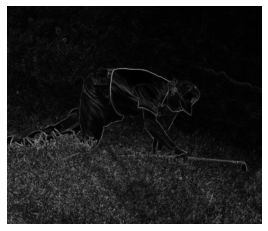

In [7]:
# Test
energy_map = find_energy_map(images[0])
plt.imshow(energy_map, cmap='gray')
plt.axis('off')
plt.show()

# II. Finding the seam with least energy

In [9]:
@jit
def backtracker(energy_map, seam_dir):

  r, c = energy_map.shape

  M = energy_map.copy()
  backtrack = np.zeros_like(M, dtype=int)

  for i in range(1, r):
      for j in range(0, c):
          if j == 0:
              idx = np.argmin(M[i - 1, j:j + 2])
              backtrack[i, j] = idx + j
              min_energy = M[i - 1, idx + j]
          else:
              idx = np.argmin(M[i - 1, j - 1:j + 2])
              if idx == 0:
                if M[i - 1, j] == M[i - 1, j - 1]:
                  idx = 1
              backtrack[i, j] = idx + j - 1
              min_energy = M[i - 1, idx + j - 1]

          M[i, j] += min_energy
  
  return M, backtrack

In [10]:
@jit
def find_seams_list(energy_map, seam_dir, seam_num): 
  
  if seam_dir == 'horizontal':
    energy_map = np.rot90(energy_map, 1, (0, 1))

  r, c = energy_map.shape
  
  seams = []
  for _ in range(seam_num):
    mask = np.ones((r, c))
    M, backtrack = backtracker(energy_map, seam_dir)
    seam = []
    j = np.argmin(M[-1])
    for i in reversed(range(r)):
      seam.append((i, j))
      j = backtrack[i, j]

      mask[i, j] = 0

    energy_map = energy_map[mask==1].reshape((r, c - 1))
    c -= 1    
    seams.append(seam)

  if seam_dir == 'horizontal':
    energy_map = np.rot90(energy_map, 3, (0, 1))

  return seams, energy_map

In [11]:
# seams_list, resized_energy_map = find_seams_list(energy_map=energy_map, seam_dir='vertical', seam_num=100)

# III. Image resizing

In [12]:
def remove_seams(img, seams_list, seam_dir):
  
  img = img.copy()

  if seam_dir == 'horizontal':
    img = np.rot90(img, 1, (0, 1))

  r, c, _ = img.shape
  org_c = c
  images = []

  for seam in seams_list:
    mask = np.ones((r, c))

    for pixel in seam:
      mask[pixel] = 0

    # To show seams
    img[mask==0] = [255, 0, 0]
    images.append(img)

    # To delete seams
    img = img[mask==1].reshape((r, c - 1, 3))
    c -= 1
    images.append(img)
  
  if seam_dir == 'horizontal':
    img = np.rot90(img, 3, (0, 1))

  return img, images

In [13]:
# img_resized, frames = remove_seams(img=images[0], seams_list=seams_list, seam_dir='vertical')

# Saving as a video to see whats happening

In [14]:
def make_video(frames, name, status='down_sample'):

  if status == 'down_sample':
    frame_temp = frames[0]

  elif status == 'up_sample':
    frame_temp = frames[-1]

  shape = frame_temp.shape[1], frame_temp.shape[0]
  out = cv2.VideoWriter('./seam_carving_{}.avi'.format(name), cv2.VideoWriter_fourcc(*'DIVX'), 15, shape)
    
  for frame in frames:
    blank = np.zeros(frame_temp.shape).astype(np.uint8)
    blank[:frame.shape[0], :frame.shape[1]] = frame
    out.write(cv2.cvtColor(blank, cv2.COLOR_RGB2BGR))

  cv2.destroyAllWindows()    
  out.release()

In [15]:
def plotter(img, energy_map, seams_list, resized_energy_map, resized_img, direction='vertical'):
  fig, axes = plt.subplots(1, 5, figsize=(25, 5))

  energy_map_color = energy_map.copy().astype(np.uint8)
  _, energy_map_color = cv2.threshold(energy_map_color, 180, 255, cv2.THRESH_BINARY)
  energy_map_color = np.stack([energy_map_color] * 3, axis=2)

  for seam in seams_list:
    for pixel in seam:

      if direction == 'horizontal':
        pixel = (pixel[1], pixel[0])

      energy_map_color[pixel] = [255, 0, 0]

  axes[0].imshow(img)
  axes[0].axis('off')

  axes[1].imshow(energy_map, cmap='gray')
  axes[1].axis('off')

  axes[2].imshow(energy_map_color)
  axes[2].axis('off')

  axes[3].imshow(resized_energy_map, cmap='gray')
  axes[3].axis('off')

  axes[4].imshow(resized_img)
  axes[4].axis('off')

  plt.show()

# Part A.


In [16]:
percentages = [0.1, 0.25, 0.5]



Width reduction by 10%



<ipython-input-10-c71c931b58cf>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "find_seams_list" failed type inference due to: Untyped global name 'reversed': cannot determine Numba type of <class 'type'>

File "<ipython-input-10-c71c931b58cf>", line 15:
def find_seams_list(energy_map, seam_dir, seam_num): 
    <source elided>
    j = np.argmin(M[-1])
    for i in reversed(range(r)):
    ^

  @jit
<ipython-input-10-c71c931b58cf>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "find_seams_list" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-input-10-c71c931b58cf>", line 10:
def find_seams_list(energy_map, seam_dir, seam_num): 
    <source elided>
  seams = []
  for _ in range(seam_num):
  ^

  @jit
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "find_

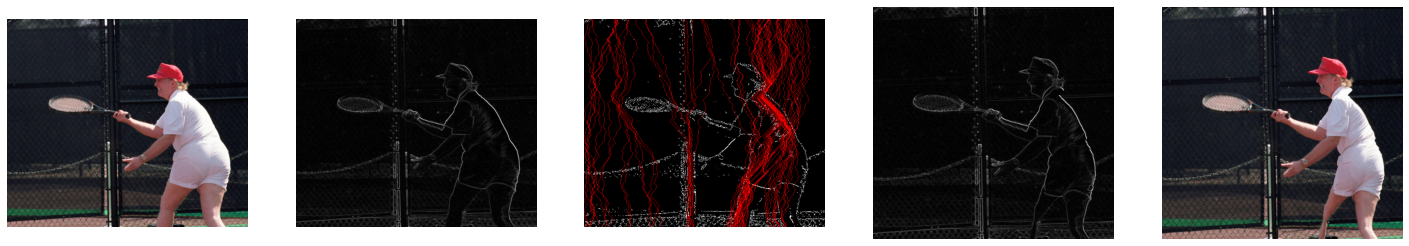



Width reduction by 25%



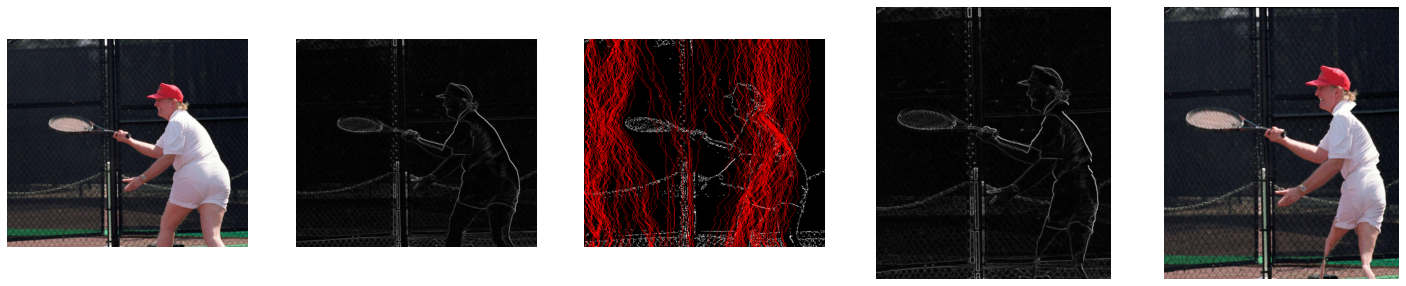



Width reduction by 50%



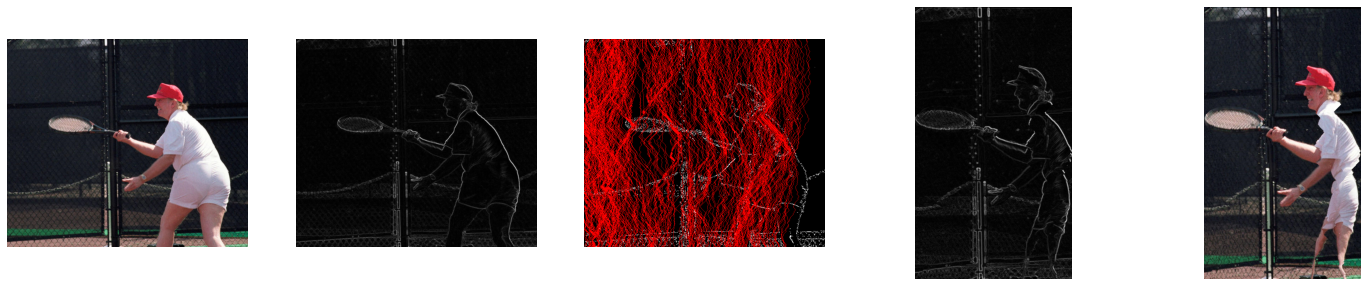

In [17]:
name = 'donald_plays_tennis'
img = images[names.index(name)]
for perc in percentages:
  print('\n\nWidth reduction by {}%\n'.format(int(perc * 100)))
  energy_map = find_energy_map(img)
  seams_list, resized_energy_map = find_seams_list(energy_map=energy_map, seam_dir='vertical', seam_num=int(img.shape[1] * perc))
  img_resized, frames = remove_seams(img=img, seams_list=seams_list, seam_dir='vertical')
  plotter(img, energy_map, seams_list, resized_energy_map, img_resized)
  make_video(frames, name=name + '_' + str(perc))

# Part B.



Height reduction by 10%



<ipython-input-10-c71c931b58cf>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "find_seams_list" failed type inference due to: Untyped global name 'reversed': cannot determine Numba type of <class 'type'>

File "<ipython-input-10-c71c931b58cf>", line 15:
def find_seams_list(energy_map, seam_dir, seam_num): 
    <source elided>
    j = np.argmin(M[-1])
    for i in reversed(range(r)):
    ^

  @jit
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "find_seams_list" was compiled in object mode without forceobj=True.

File "<ipython-input-10-c71c931b58cf>", line 10:
def find_seams_list(energy_map, seam_dir, seam_num): 
    <source elided>
  seams = []
  for _ in range(seam_num):
  ^

  state.func_ir.loc))
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation 

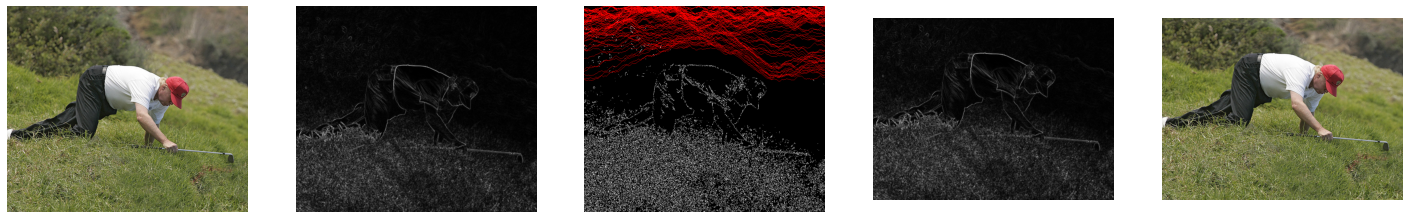



Height reduction by 25%



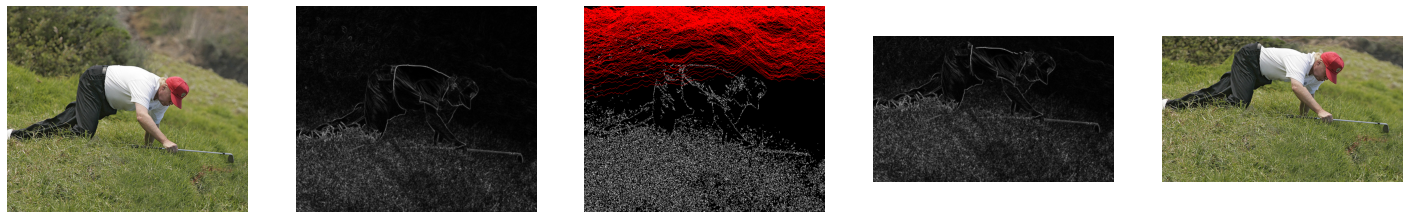



Height reduction by 50%



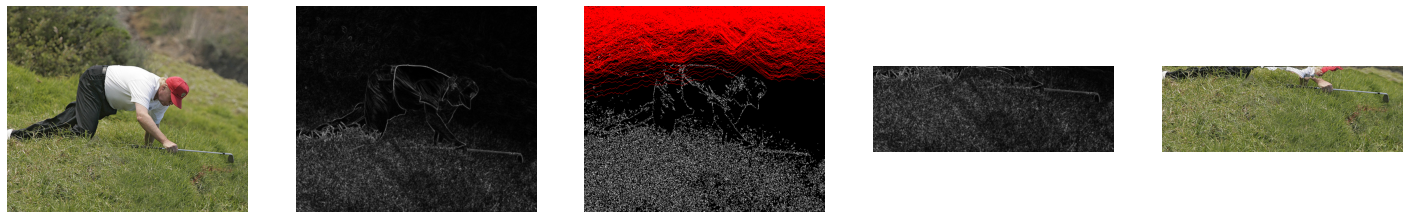

In [18]:
name = 'donald_plays_golf'
img = images[names.index(name)]
for perc in percentages:
  print('\n\nHeight reduction by {}%\n'.format(int(perc * 100)))
  energy_map = find_energy_map(img)
  seams_list, resized_energy_map = find_seams_list(energy_map=energy_map, seam_dir='horizontal', seam_num=int(img.shape[1] * perc))
  img_resized, frames = remove_seams(img=img, seams_list=seams_list, seam_dir='horizontal')
  plotter(img, energy_map, seams_list, resized_energy_map, img_resized, direction='horizontal')
  make_video(frames, name=name + '_' + str(perc))

# Part C.

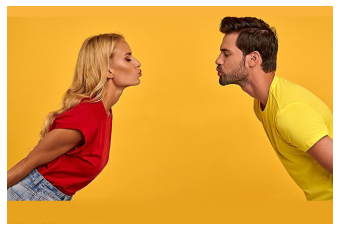

In [19]:
name = 'kiss'
img = images[names.index(name)]
plt.imshow(img)
plt.axis('off')
plt.show()

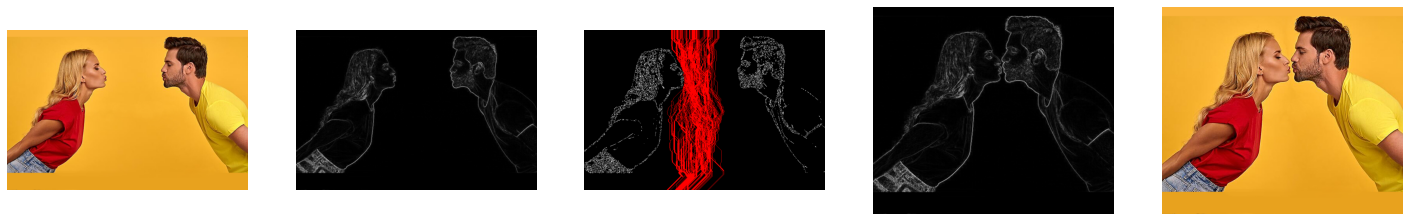

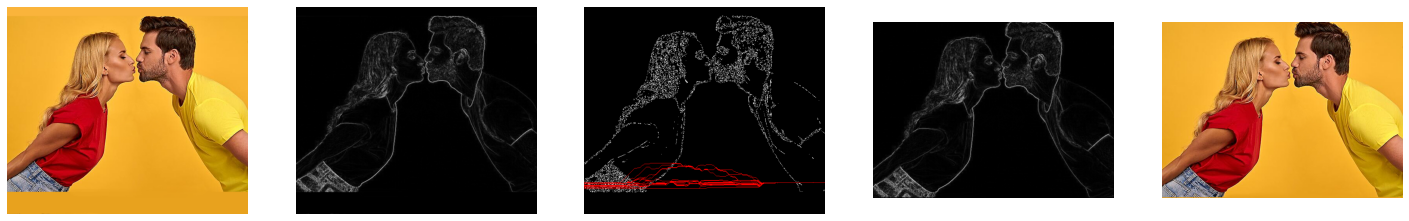

In [20]:
energy_map = find_energy_map(img)
seams_list, resized_energy_map = find_seams_list(energy_map=energy_map, seam_dir='vertical', seam_num=int(img.shape[1] * 0.225))
img_resized_v, frames = remove_seams(img=img, seams_list=seams_list, seam_dir='vertical')
plotter(img, energy_map, seams_list, resized_energy_map, img_resized_v)
frames_v = frames

energy_map = find_energy_map(img_resized_v)
seams_list, resized_energy_map = find_seams_list(energy_map=energy_map, seam_dir='horizontal', seam_num=int(img_resized_v.shape[1] * 0.13))
img_resized_h, frames_h = remove_seams(img=img_resized_v, seams_list=seams_list, seam_dir='horizontal')
plotter(img_resized_v, energy_map, seams_list, resized_energy_map, img_resized_h, direction='horizontal')

frames_h_fixed = []
for frame in frames_h:
  frames_h_fixed.append(np.rot90(frame, 3, (0, 1)))

make_video(frames_v + frames_h_fixed, name=name)

# Part D.

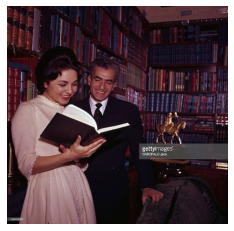

In [21]:
name = 'm_reza_shah_farah_library'
img = images[names.index(name)]
plt.imshow(img)
plt.axis('off')
plt.show()

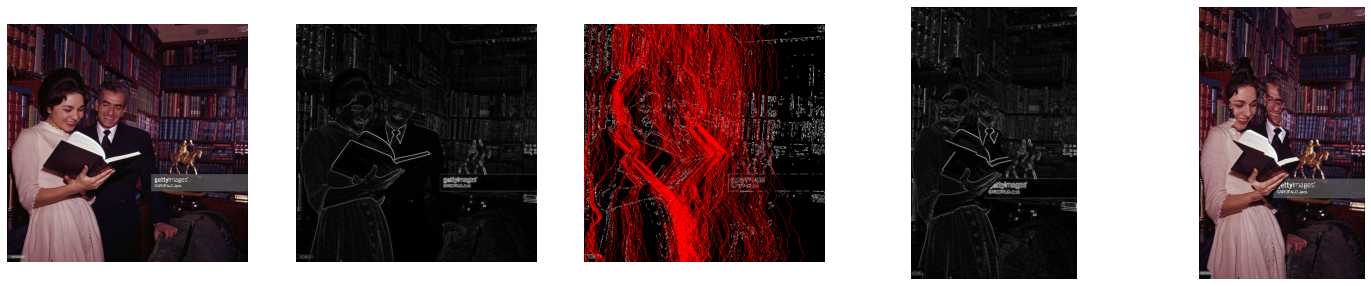

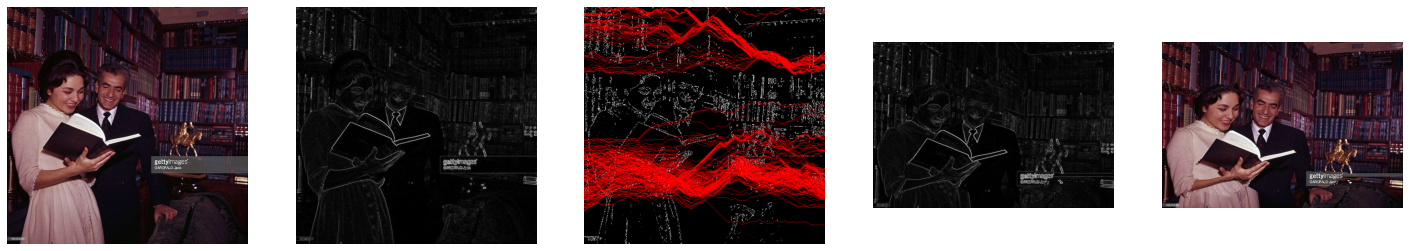

In [22]:
energy_map = find_energy_map(img)
seams_list, resized_energy_map = find_seams_list(energy_map=energy_map, seam_dir='vertical', seam_num=int(img.shape[1] * 0.4))
img_resized_v, frames = remove_seams(img=img, seams_list=seams_list, seam_dir='vertical')
plotter(img, energy_map, seams_list, resized_energy_map, img_resized_v)
make_video(frames, name=name)

energy_map = find_energy_map(img)
seams_list, resized_energy_map = find_seams_list(energy_map=energy_map, seam_dir='horizontal', seam_num=int(img.shape[1] * 0.3))
img_resized_h, frames_h = remove_seams(img=img, seams_list=seams_list, seam_dir='horizontal')
plotter(img, energy_map, seams_list, resized_energy_map, img_resized_h, direction='horizontal')

frames_h_fixed = []
for frame in frames_h:
  frames_h_fixed.append(np.rot90(frame, 3, (0, 1)))

make_video(frames_h_fixed, name=name)

# Part E.

In [23]:
def add_col(img, mask):
  blank = np.zeros(np.add(img.shape, [0, 1, 0])).astype(np.uint8)
  for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
      if mask[i, j] == 0:
        blank[i, :j + 1] = img[i, :j + 1]
        blank[i, j + 1] = img[i, j]
        blank[i, j + 2:] = img[i, j + 1:]
  
  return blank

In [24]:
def add_seams(img, seams_list, seam_dir):
  
  img = img.copy()

  if seam_dir == 'horizontal':
    img = np.rot90(img, 1, (0, 1))

  r, c, _ = img.shape
  org_c = c
  images = []

  for seam in seams_list:
    mask = np.ones((r, c))

    for pixel in seam:
      mask[pixel] = 0

    # To show seams
    img_temp = img.copy()
    img_temp[mask==0] = [255, 0, 0]
    images.append(img_temp)

    # To add seams
    img = add_col(img, mask)
    c += 1
    images.append(img)
  
  if seam_dir == 'horizontal':
    img = np.rot90(img, 3, (0, 1))

  return img, images



Width increase by 10%



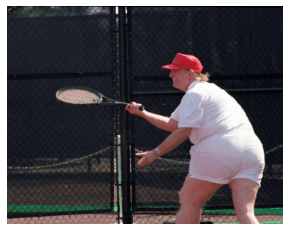



Width increase by 25%



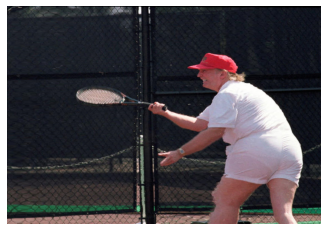



Width increase by 50%



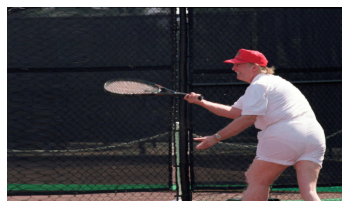

In [25]:
name = 'donald_plays_tennis'
img = images[names.index(name)]
for perc in percentages:
  print('\n\nWidth increase by {}%\n'.format(int(perc * 100)))
  energy_map = find_energy_map(img)
  seams_list, resized_energy_map = find_seams_list(energy_map=energy_map, seam_dir='vertical', seam_num=int(img.shape[1] * perc))
  img_resized, frames = add_seams(img=img, seams_list=seams_list, seam_dir='vertical')

  plt.imshow(img_resized)
  plt.axis('off')
  plt.show()
  make_video(frames, name=name + '_' + str(perc), status='up_sample')



Height increase by 10%



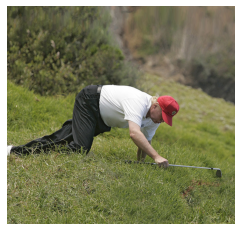



Height increase by 25%



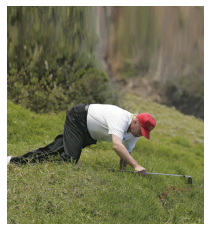



Height increase by 50%



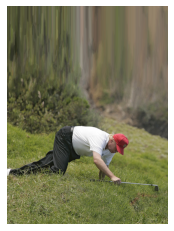

In [26]:
name = 'donald_plays_golf'
img = images[names.index(name)]
for perc in percentages:
  print('\n\nHeight increase by {}%\n'.format(int(perc * 100)))
  energy_map = find_energy_map(img)
  seams_list, resized_energy_map = find_seams_list(energy_map=energy_map, seam_dir='horizontal', seam_num=int(img.shape[1] * perc))
  img_resized, frames = add_seams(img=img, seams_list=seams_list, seam_dir='horizontal')
  
  plt.imshow(img_resized)
  plt.axis('off')
  plt.show()
  make_video(frames, name=name + '_' + str(perc), status='up_sample')

# Part F.

In [27]:
def get_mask_size(mask):
  min_j = np.inf
  max_j = 0
  for j in range(mask.shape[1]):
    for i in range(mask.shape[0]):
      if (mask[i, j] == [255, 255, 255]).all():
        if j > max_j:
          max_j = j
        if j < min_j:
          min_j = j
  
  return max_j - min_j    

In [28]:
name = 'trump_putin'
img = images[names.index(name)]
mask = images[names.index(name + '_mask')]

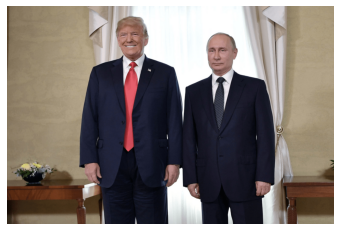

In [29]:
plt.imshow(img)
plt.axis('off')
plt.show()

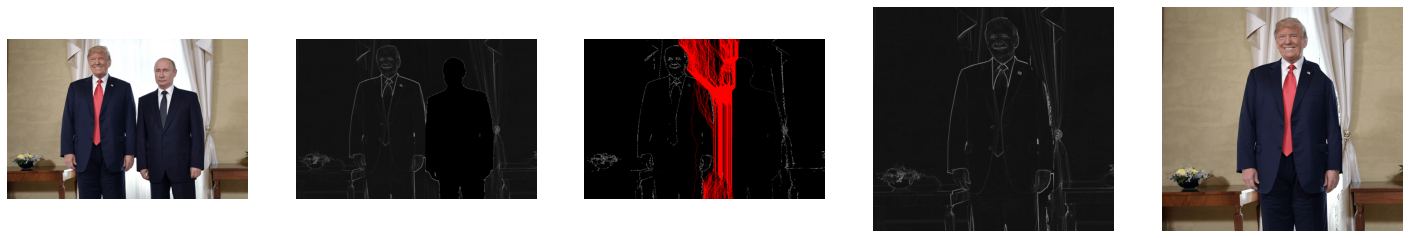

In [30]:
energy_map = find_energy_map(img, mask)
seam_num = get_mask_size(mask)
seams_list, resized_energy_map = find_seams_list(energy_map=energy_map, seam_dir='vertical', seam_num=seam_num)
img_resized, frames_down = remove_seams(img=img, seams_list=seams_list, seam_dir='vertical')
plotter(img, energy_map, seams_list, resized_energy_map, img_resized)

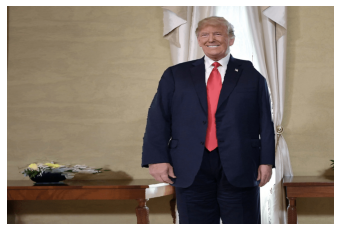

In [31]:
energy_map = find_energy_map(img_resized)
seams_list, resized_energy_map = find_seams_list(energy_map=energy_map, seam_dir='vertical', seam_num=seam_num)
img_resized, frames_up = add_seams(img=img_resized, seams_list=seams_list, seam_dir='vertical')

plt.imshow(img_resized)
plt.axis('off')
plt.show()
make_video(frames_down + frames_up, name=name, status='up_sample')

In [32]:
name = 'trump_queen'
img = images[names.index(name)]
mask = images[names.index(name + '_mask')]

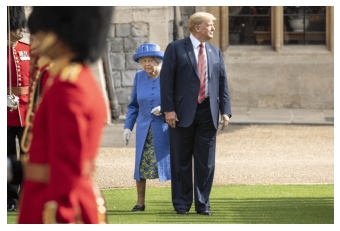

In [33]:
plt.imshow(img)
plt.axis('off')
plt.show()

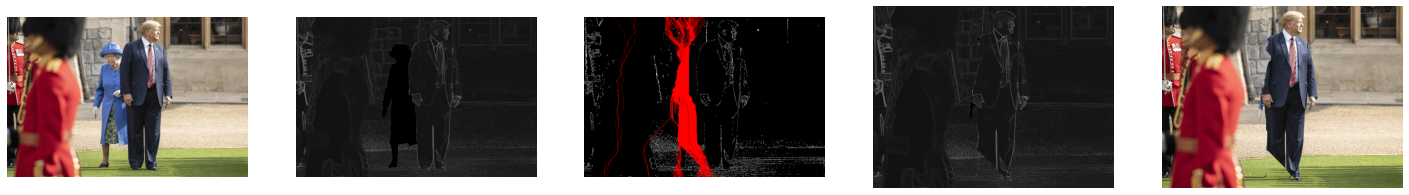

In [34]:
energy_map = find_energy_map(img, mask)
seam_num = get_mask_size(mask) - 35
seams_list, resized_energy_map = find_seams_list(energy_map=energy_map, seam_dir='vertical', seam_num=seam_num)
img_resized, frames_down = remove_seams(img=img, seams_list=seams_list, seam_dir='vertical')
plotter(img, energy_map, seams_list, resized_energy_map, img_resized)

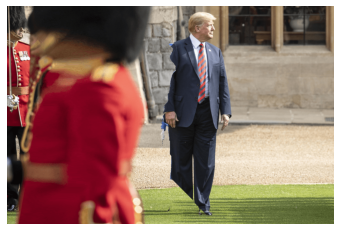

In [35]:
energy_map = find_energy_map(img_resized)
seams_list, resized_energy_map = find_seams_list(energy_map=energy_map, seam_dir='vertical', seam_num=seam_num)
img_resized, frames_up = add_seams(img=img_resized, seams_list=seams_list, seam_dir='vertical')

plt.imshow(img_resized)
plt.axis('off')
plt.show()
make_video(frames_down + frames_up, name=name, status='up_sample')